## Problem Definition and Data Collection

In this analysis, I delve into a dataset from Salifort Motor comprising 15,000 rows and 10 variables. My objective is to unearth insights into the factors driving attrition and to develop predictions regarding individuals likely to depart.

![](images/Employee_Attrition.jpeg){fig-align="center"}

### Import packages

- Import packages for : data manipulation, data visualization, data modeling, metrics calculation and other helpful functions.


In [2]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Setup theme display
sns.set_theme(color_codes=True)

# Set the display format for floating point numbers
pd.options.display.float_format = '{:,.3f}'.format

### Load dataset

- Load dataset into dataframe `HR_capstone_dataset.csv` and display few rows 

In [3]:
#| echo: false
# Load dataset into a dataframe
df = pd.read_csv("../data/HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low


## Data Cleaning and Preprocessing

Clean the data, handle missing values, outliers, and inconsistencies, and preprocess it for analysis.

### Gather basic information about the data

In [4]:
# Gather basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  

### Gather descriptive statistics about the data

In [5]:
# Gather descriptive statistics about the data
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,"14,999.000","14,999.000","14,999.000","14,999.000","14,999.000","14,999.000","14,999.000","14,999.000"
mean,0.613,0.716,3.803,201.050,3.498,0.145,0.238,0.021
std,0.249,0.171,1.233,49.943,1.460,0.352,0.426,0.144
min,0.090,0.360,2.000,96.000,2.000,0.000,0.000,0.000
25%,0.440,0.560,3.000,156.000,3.000,0.000,0.000,0.000
50%,0.640,0.720,4.000,200.000,3.000,0.000,0.000,0.000
75%,0.820,0.870,5.000,245.000,4.000,0.000,0.000,0.000
max,1.000,1.000,7.000,310.000,10.000,1.000,1.000,1.000


### Rename columns

Standardize the column names so that they are all in snake_case, correct any column names that are misspelled, and make column names more concise as needed.

- All current column names:

In [6]:
# Display all column names
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

- Columns after rename:

In [7]:
column_mapping = {
        'satisfaction_level': 'satisfaction',
        'last_evaluation': 'evaluation',
        'number_project': 'num_projects',
        'average_montly_hours': 'avg_monthly_hours',
        'time_spend_company': 'tenure',
        'Work_accident': 'work_accident',
        'promotion_last_5years': 'promotion_in_last_5_years',
        'Department': 'department'
    }

# Rename columns based on the mapping
df.rename(columns=column_mapping, inplace=True)

# Convert column names to snake_case
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Display all column names after the update
df.dtypes

satisfaction                 float64
evaluation                   float64
num_projects                   int64
avg_monthly_hours              int64
tenure                         int64
work_accident                  int64
left                           int64
promotion_in_last_5_years      int64
department                    object
salary                        object
dtype: object

### Check missing values

- Check for any missing values in the dataset

In [8]:
df.isna().sum()

satisfaction                 0
evaluation                   0
num_projects                 0
avg_monthly_hours            0
tenure                       0
work_accident                0
left                         0
promotion_in_last_5_years    0
department                   0
salary                       0
dtype: int64

### Check duplicates

- Check for any duplicate entries in the data.

In [9]:
# Check for duplicates
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()

# Display duplicate rows
if not duplicate_rows.empty:
    print("Number of duplicate rows:", num_duplicates)
else:
    print("No duplicate rows found.")

Number of duplicate rows: 3008
Number of duplicate rows: 3008


::: {.callout-tip}
### Finding 1:
3,008 rows contain duplicates. That is 20% of the data.

:::

- Let's inspect some rows containing duplicates:

In [10]:
# Inspect some rows containing duplicates as needed
df[duplicate_rows].sort_values(by=list(df.columns)).head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,left,promotion_in_last_5_years,department,salary
12030,0.090,0.620,6,294,4,0,1,0,accounting,low
14241,0.090,0.620,6,294,4,0,1,0,accounting,low
12071,0.090,0.770,5,275,4,0,1,0,product_mng,medium
14282,0.090,0.770,5,275,4,0,1,0,product_mng,medium
12652,0.090,0.770,6,290,4,0,1,0,technical,medium


- OK, then remove duplicates. And take a look few rows of new dataframe:

In [11]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df = df.drop_duplicates(keep='first')

# Display first few rows of new dataframe as needed
df.head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,left,promotion_in_last_5_years,department,salary
0,0.380,0.530,2,157,3,0,1,0,sales,low
1,0.800,0.860,5,262,6,0,1,0,sales,medium
2,0.110,0.880,7,272,4,0,1,0,sales,medium
3,0.720,0.870,5,223,5,0,1,0,sales,low
4,0.370,0.520,2,159,3,0,1,0,sales,low


### Convert infinite values

- We found some infinite values, then converted them to NaN

In [12]:
# Convert infinite values to NaN in your DataFrame
df.replace([np.inf, -np.inf], np.nan, inplace=True)

### Check outliers

- Visualise boxplot to check for outliers in the data.

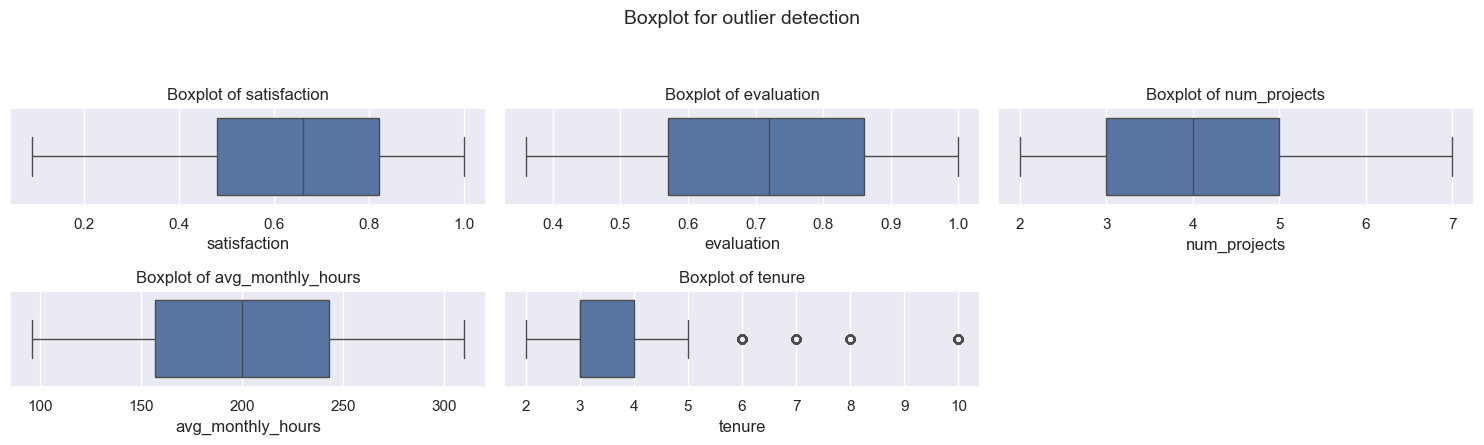

In [13]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers

columns_to_check = ['satisfaction', 'evaluation', 'num_projects', 'avg_monthly_hours', 'tenure']

plt.figure(figsize=(15, 8))
plt.suptitle('Boxplot for outlier detection', fontsize=14)
for i, column in enumerate(columns_to_check, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The boxplot above shows that there are outliers in the `tenure` variable. 

We can also use IQR to check outliers with assumption any data point below the *`lower bound (=Q1-1.5*IQR)`* or above the *`upper bound (=Q3+1.5*IQR)`* is considered an outlier.

In [14]:
# Determine the number of rows containing outliers
columns_to_check = ['satisfaction', 'evaluation', 'num_projects', 'avg_monthly_hours', 'tenure']

# Calculate summary statistics
summary_stats = df[columns_to_check].describe()

# Calculate IQR for each column
Q1 = summary_stats.loc['25%']
Q3 = summary_stats.loc['75%']
max_ = summary_stats.loc['max']
IQR = Q3 - Q1

# Identify potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
have_outliers = max_ > upper_bound

# Display potential outliers
outliers = ((df[columns_to_check] < lower_bound) | (df[columns_to_check] > upper_bound)).any(axis=1)
potential_outliers = df[outliers][columns_to_check]

# Create a new DataFrame to store summary statistics and outlier information
outlier_info = pd.DataFrame({
    'IQR(Q3-Q1)': IQR,
    'Lower Bound': lower_bound,
    'Upper Bound': upper_bound,    
    'Have Outliers': have_outliers
})

# Transpose the outlier_info DataFrame to match the shape of summary_stats
outlier_info = outlier_info.transpose()

# Combine summary statistics and outlier information
summary_stats = pd.concat([summary_stats, outlier_info])

# Highlight 'Have Outliers' row
def highlight_outliers_row(row):
    if row.name == 'Have Outliers':
        return ['background-color: yellow']*len(row)
    else:
        return ['']*len(row)

# Display the combined DataFrame
#summary_stats

summary_stats_highlighted = summary_stats.style.apply(highlight_outliers_row, axis=1)
summary_stats_highlighted

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure
count,11991.000000,11991.000000,11991.000000,11991.000000,11991.000000
mean,0.629658,0.716683,3.802852,200.473522,3.364857
std,0.241070,0.168343,1.163238,48.727813,1.330240
min,0.090000,0.360000,2.000000,96.000000,2.000000
25%,0.480000,0.570000,3.000000,157.000000,3.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000
IQR(Q3-Q1),0.340000,0.290000,2.000000,86.000000,1.000000
Lower Bound,-0.030000,0.135000,0.000000,28.000000,1.500000


It would be helpful to investigate how many rows in the data contain outliers in the `tenure` column:

In [15]:
potential_outliers

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure
1,0.800,0.860,5,262,6
17,0.780,0.990,4,255,6
34,0.840,0.870,4,246,6
47,0.570,0.700,3,273,6
67,0.900,0.980,4,264,6
...,...,...,...,...,...
11994,0.220,0.940,3,193,10
11995,0.900,0.550,3,259,10
11996,0.740,0.950,5,266,10
11997,0.850,0.540,3,185,10


::: {.callout-tip}
### Finding 2: 

The potential outliers are in the `tenure` variable, where values are greater than 5.5.

:::

Certain types of models are more sensitive to outliers than others. When you get to the stage of building your model, consider whether to remove outliers, based on the type of model you decide to use.

## Exploratory Data Analysis (EDA)

Explore the data, gain insights, visualize patterns, and engineer new features to improve modeling.

### Percentages of people who left vs. stayed

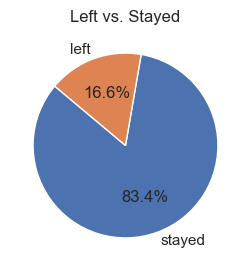

In [16]:
# Visualise percentages of people who left vs. stayed
class_counts = df['left'].value_counts()
#labels = class_counts.index
labels = ['stayed','left']
sizes = class_counts.values

plt.figure(figsize=(3, 3))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Left vs. Stayed');

::: {.callout-tip}
### Finding 3:
- The attrition rate, represented by the proportion of employees who have left the company, is 16.60% based on a sample size of 11,991 observations.
- This indicates a moderately imbalanced dataset, with a larger proportion of observations belonging to the 'not left' or 'stayed' class compared to the 'left' class.

:::

### Data Visualization

Now, examine variables that you're interested in, and create plots to visualize relationships between variables in the data.

#### Univariate Analysis: 

Analyse Relationship with the target variable

- Plot histograms or kernel density plots for numerical variables to understand their distributions.
- For categorical variables, create bar plots to visualize their distribution.

##### Distribution of  numeric variables over the target variable

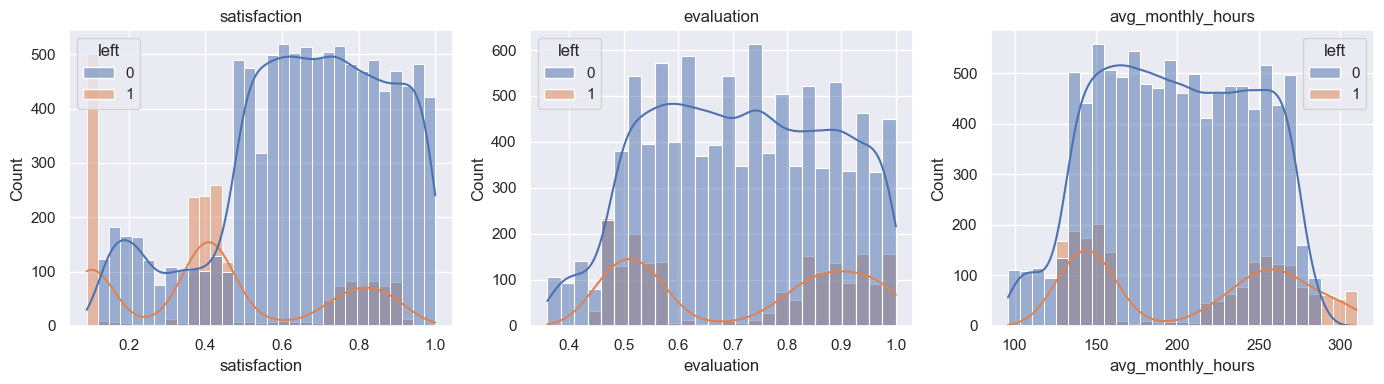

In [17]:
# Get the name of colunms
cols = ['satisfaction','evaluation','avg_monthly_hours']

# Set up the matplotlib figure
num_cols = len(cols)
num_rows = (len(cols)+2)//3 # To makesure there are enought row for subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 3, figsize=(14, 4*num_rows))
axs = axs.flatten()

# Plot histograms for each integer variable
for i, var in enumerate(cols):
    sns.histplot(data=df, x=var, hue='left',kde=True, ax=axs[i])
    axs[i].set_title(var)
    
# Remove any empty subplot if need
if num_cols < len(axs):
    for i in range(num_cols,len(axs)):
        fig.delaxes(axs[i])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

If we assume a work week of 40 hours and two weeks of vacation per year, then the average number of working hours per month of employees working Monday&ndash;Friday `= 50 weeks * 40 hours per week / 12 months = 166.7 hours per month`.

Let's take a closer look to `avg_monthly_hours` with **the average number of working hours per month ~ 166.7 hours**

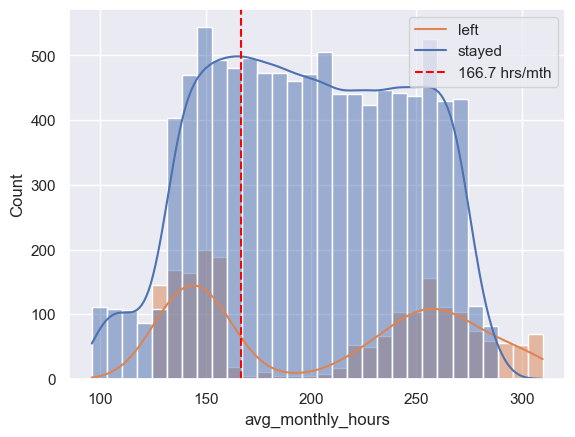

In [18]:
#df_mth_hr = df[df['avg_monthly_hours'] > 286]
sns.histplot(data = df, x= 'avg_monthly_hours',bins=30, kde=True,hue='left');
plt.axvline(x=166.7, color='red', linestyle='--')
plt.legend(labels=['left', 'stayed','166.7 hrs/mth']);

::: {.callout-tip}
### Finding

- **satisfaction**: 
    - There is a group of 501 employees with satisfaction levels less than 0.12 leaving the company, with 500 of them not having been promoted in the last 5 years. Within the total of 1991 employees who left the company, this subgroup constitutes one-fourth, suggesting that it should be separated for further analysis.
    - The distribution also indicates that employees are:
         - Likely to leave when their satisfaction level is between 0.36 and 0.46.
         -  Likely to stay when their satisfaction level is higher than 0.46.   
- **evaluation**:
    - There are two groups of evaluation score which show signs of leaving: arround 0.5 and from 0.8 to 1.0
- **avg_monthly_hours**:
    - There is a group of 238 employees working over 287 hours per month who are likely to leave the company.

:::

##### Visualization of catergory variables over the target variable

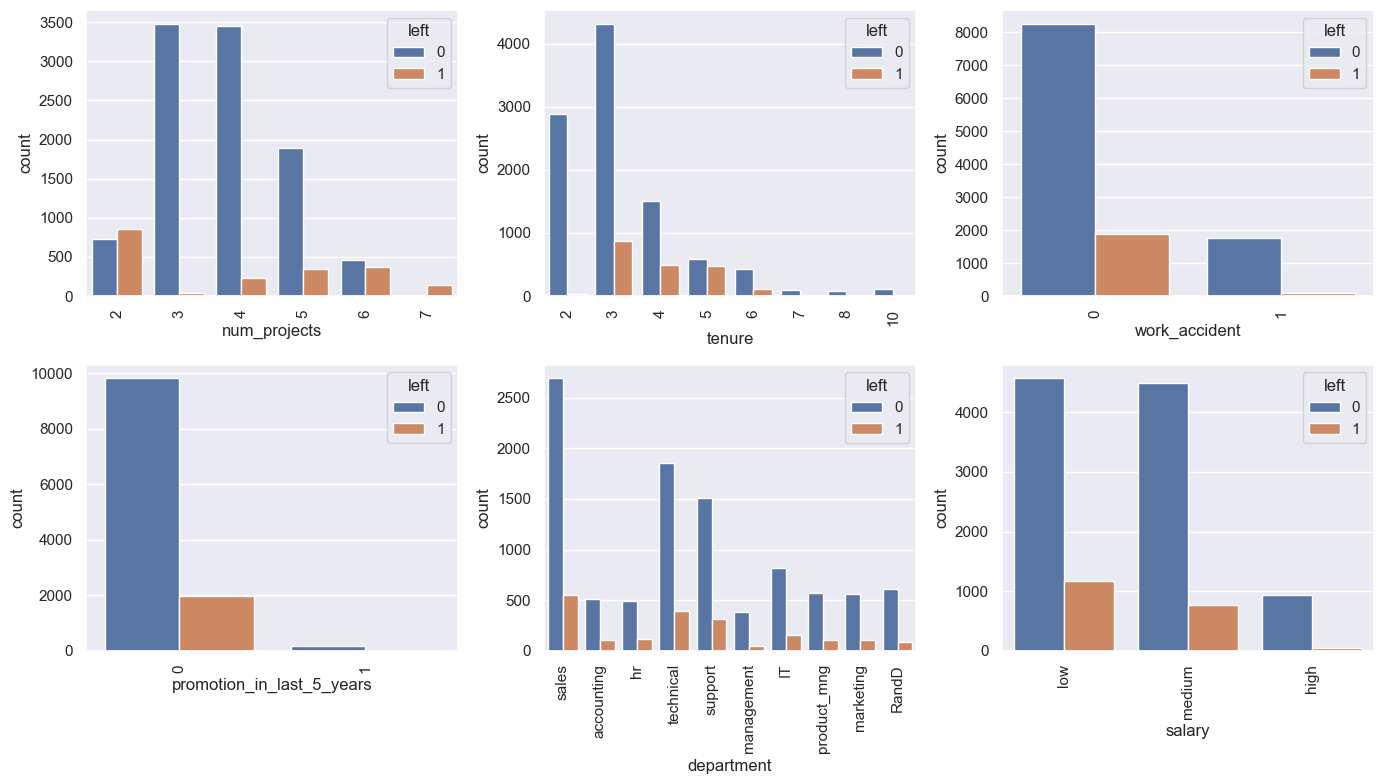

In [19]:
# Get the name of colunms
cols = ['num_projects','tenure','work_accident',
                         'promotion_in_last_5_years','department', 'salary']

# Set up the matplotlib figure
num_cols = len(cols)
num_rows = (len(cols)+2)//3 # To makesure there are enought row for subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 3, figsize=(14, 4*num_rows))
axs = axs.flatten()

# Plot histograms for each integer variable
for i, var in enumerate(cols):
    sns.countplot(data=df, x=var, hue='left', ax=axs[i])
#   axs[i].set_title(var)
    axs[i].tick_params(axis='x',rotation=90)
    
# Remove any empty subplot if need
if num_cols < len(axs):
    for i in range(num_cols,len(axs)):
        fig.delaxes(axs[i])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Another view of categorical variables in relation to the target variable, presented as percentages.

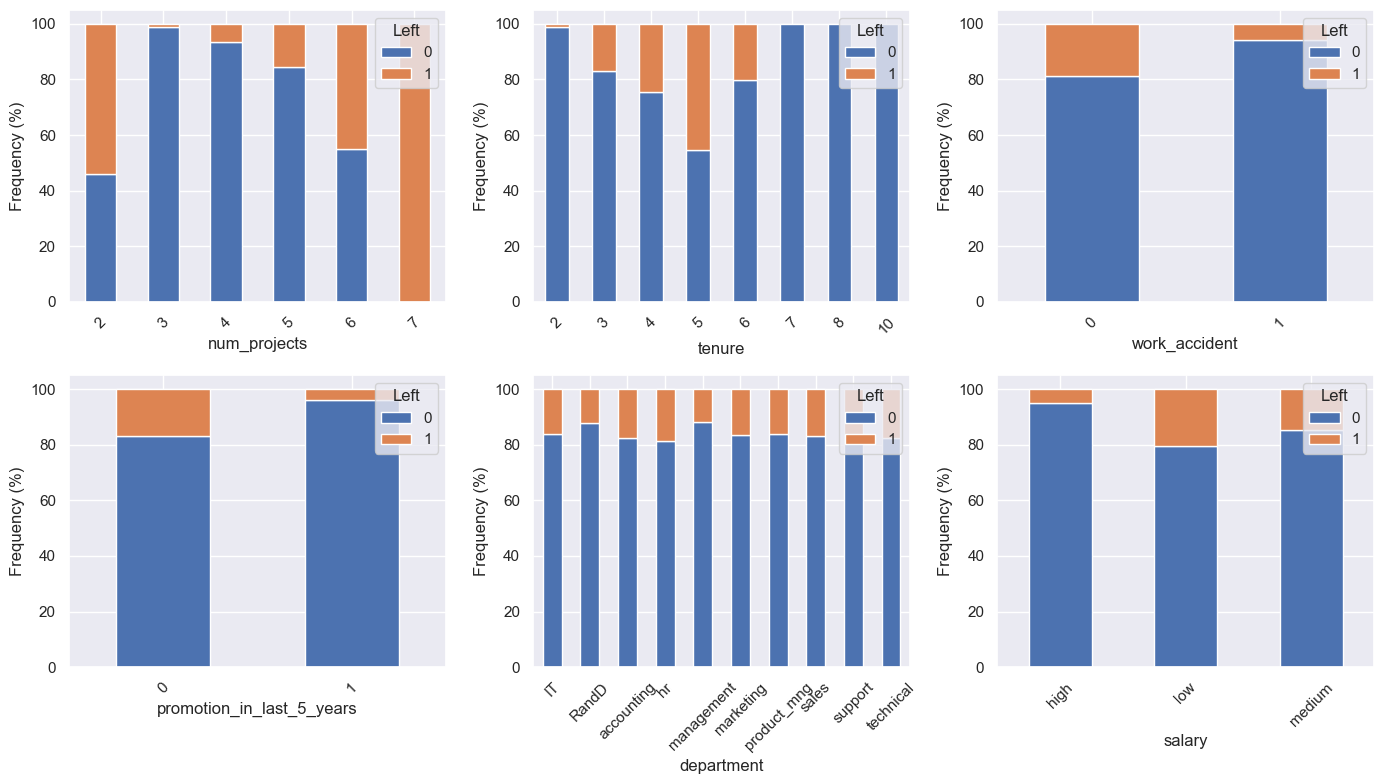

In [20]:
# Get the name of colunms
cols = ['num_projects','tenure','work_accident',
                         'promotion_in_last_5_years','department', 'salary']

# Set up the matplotlib figure
num_cols = len(cols)
num_rows = (len(cols)+2)//3 # To makesure there are enought row for subplot
fig, axs = plt.subplots(nrows = num_rows, ncols = 3, figsize=(14, 4*num_rows))
axs = axs.flatten()

# Plot histograms for each integer variable
for i, var in enumerate(cols):
    percentage_left = (df.groupby(var)['left'].value_counts(normalize=True) * 100).unstack().fillna(0)
    
    # Plot
    percentage_left.plot(kind='bar', stacked=True, ax=axs[i])
    axs[i].set_ylabel('Frequency (%)')
    axs[i].set_xlabel(var)
    axs[i].legend(title='Left', loc='upper right')
    axs[i].tick_params(axis='x', rotation=45)
    
        
for j in range(num_cols, num_rows * 3):
    axs[j].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

- Count and proportion of catergory variables over the target variable:

In [21]:
for var in cols:
    count_table = df.groupby(var)['left'].value_counts().unstack(fill_value=0)
    percentage_table = df.groupby(var)['left'].value_counts(normalize=True).unstack(fill_value=0) * 100
    
    display(pd.concat([count_table, percentage_table], axis=1, keys=['Count', 'Percentage (%)'], names=['', 'Left']))

Count      Percentage (%)        
Left             0    1              0       1
num_projects                                  
2              725  857         45.828  54.172
3             3482   38         98.920   1.080
4             3448  237         93.569   6.431
5             1890  343         84.639  15.361
6              455  371         55.085  44.915
7                0  145          0.000 100.000

Count      Percentage (%)       
Left       0    1              0      1
tenure                                 
2       2879   31         98.935  1.065
3       4316  874         83.160 16.840
4       1510  495         75.312 24.688
5        580  482         54.614 45.386
6        433  109         79.889 20.111
7         94    0        100.000  0.000
8         81    0        100.000  0.000
10       107    0        100.000  0.000

Count       Percentage (%)       
Left              0     1              0      1
work_accident                                  
0              8255  1886         81.402 18.598
1              1745   105         94.324  5.676

Count       Percentage (%)       
Left                          0     1              0      1
promotion_in_last_5_years                                  
0                          9805  1983         83.178 16.822
1                           195     8         96.059  3.941

Count      Percentage (%)       
Left            0    1              0      1
department                                  
IT            818  158         83.811 16.189
RandD         609   85         87.752 12.248
accounting    512  109         82.448 17.552
hr            488  113         81.198 18.802
management    384   52         88.073 11.927
marketing     561  112         83.358 16.642
product_mng   576  110         83.965 16.035
sales        2689  550         83.019 16.981
support      1509  312         82.867 17.133
technical    1854  390         82.620 17.380

Count       Percentage (%)       
Left       0     1              0      1
salary                                  
high     942    48         95.152  4.848
low     4566  1174         79.547 20.453
medium  4492   769         85.383 14.617

::: {.callout-tip}
### Finding 4

- **num_projects**:
    - Employees with 3,4 projects are likely to stay.
    - All 145 employees with 7 projects left the company.

- **tenure**:
    - Employees with 2,3 years in company are more likely to stay. The leave rate increases from 24.68% to 45.38% for employees with 4 or 5 years in company and decreases to 20.11% for those with 6 years in_company.
    - All 282 employees working higher than 6 years in company stayed with the company.

- **work_accident**:
    - It seems that the occurrence of work accidents itself may not significantly impact the decision to leave the company. For instance, 18.59% of employees with no work accidents left the company, which is higher than the 5.68% leaving from the group of employees who did experience work accidents."

- **promotion_in_last_5_years**:
    - This might be one of the factors influencing employees' decisions to leave the company. For example, 16.82% of employees who have not been promoted in the last 5 years left the company, compared to 3.94% who left despite receiving a promotion in the last 5 years.
    - Another point to note is that among the 1983 employees who left the company, there may be a correlation with not having been promoted in the last 5 years. Specifically, 500 of these employees rated their satisfaction level below 0.12, which could also be an indicator for leaving

- **department**:
    - The attrition rate among departments is arround 16%-18%, except for the Management and R&D department with the left rate from 11.93%-12.04%.

- **salary**:
    - The attrition rate decrease as the salary increase from low to high.

:::

#### Bivariate analysis: 

Explore relationships between pairs of variables.

##### Explore `Number_of_project` vs `avg_monthly_hours` over target variable

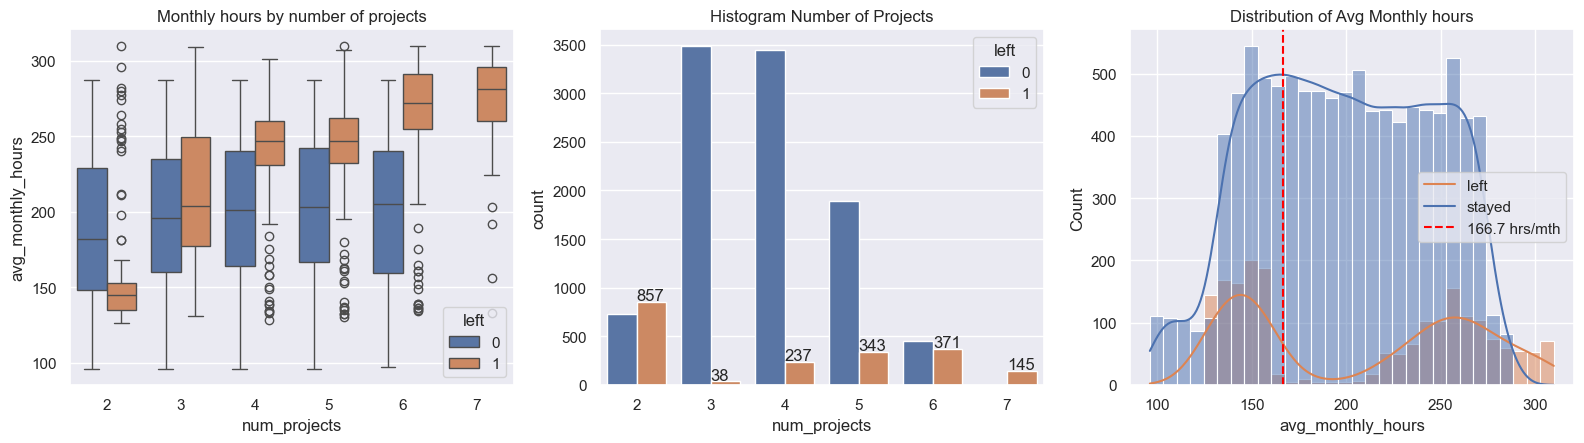

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

sns.boxplot(ax=axes[0], data=df, x='num_projects', y='avg_monthly_hours', hue='left')
axes[0].set_title('Monthly hours by number of projects')

sns.countplot(ax=axes[1], data=df, x='num_projects', hue ='left')
axes[1].set_title('Histogram Number of Projects')
left_counts = df[df['left'] == 1]['num_projects'].value_counts().sort_index()
for i, count in enumerate(left_counts):
    axes[1].text(i, count + 15, str(count), ha='left')

sns.histplot(ax=axes[2],data = df, x= 'avg_monthly_hours',bins=30, kde=True,hue='left')
axes[2].set_title('Distribution of Avg Monthly hours')
axes[2].axvline(x=166.7, color='red', linestyle='--')
axes[2].legend(labels=['left', 'stayed','166.7 hrs/mth']);

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

::: {.callout-tip}
### Finding 5




- All 145 employees working on 7 projects have left the company, and most of those who left while working on 6 projects were averaging approximately 255-295 hours per month, higher than any other group.
- Assuming the working week in a whole year is 50 weeks, with a standard working hour per week of 40 hours, the average working hours per month would be calculated as follows: 

$$
\text{Average working hours per month} = \left( \frac{{40 \text{ hours/week} \times 50 \text{ weeks}}}{{12 \text{ months}}} \right) = \textbf{166.7 hrs/mth}
$$

- More than 2/3 of employees have an average working hour per month higher than this standard, indicating that **employees are likely overworked**.
- The optimal number of projects is 3 and 4, where the attrition rate is low.

:::


*We will continue to analyse subset of employees who left the company.*

##### Scatter plot for employees who left the company.

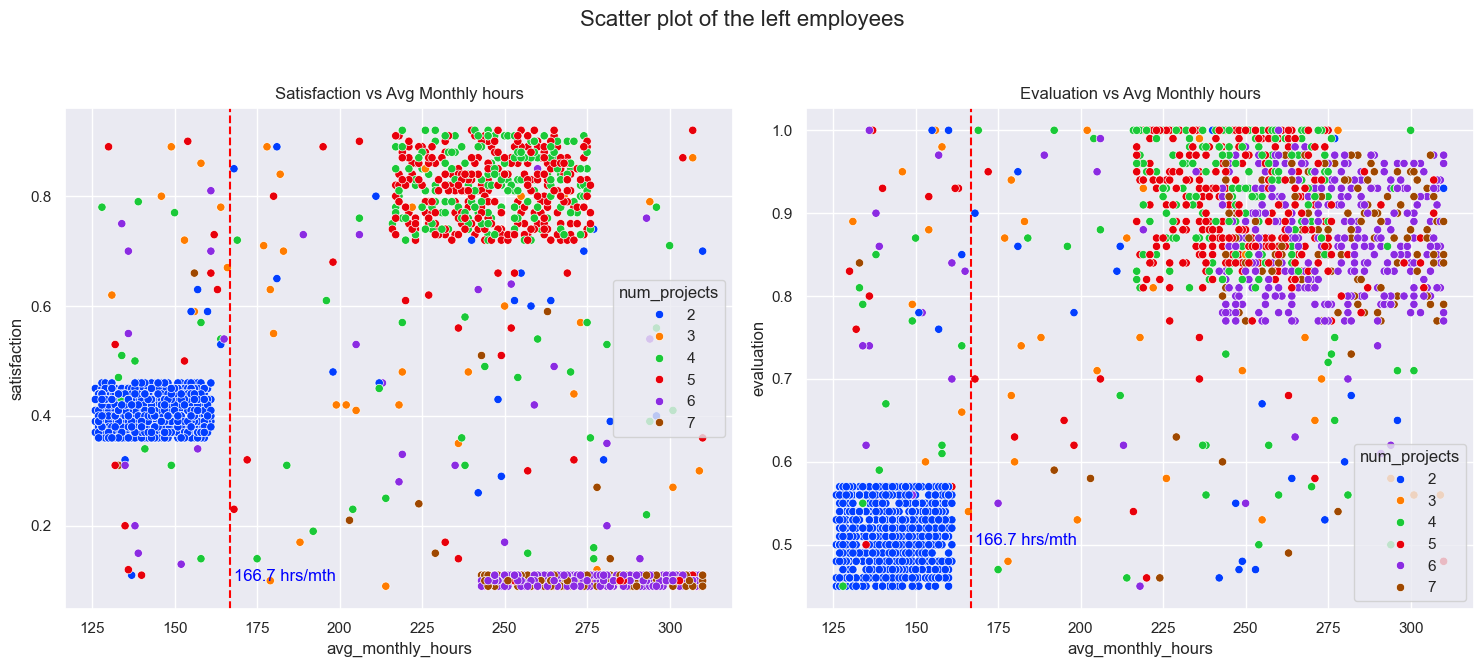

In [23]:
df_left = df[df['left'] == 1]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
fig.suptitle('Scatter plot of the left employees', fontsize=16)

# satisfaction vs avg_monthly_hours
sns.scatterplot(ax=axes[0], data=df_left, x='avg_monthly_hours', y='satisfaction', hue = 'num_projects',
               palette='bright')
axes[0].set_title('Satisfaction vs Avg Monthly hours')
axes[0].axvline(x=166.7, color='red', linestyle='--')
axes[0].text(168, 0.1, '166.7 hrs/mth', color='blue', fontsize=12)

# evaluation vs avg_monthly_hours
sns.scatterplot(ax=axes[1], data=df_left, x='avg_monthly_hours', y='evaluation', hue = 'num_projects',
               palette='bright')
axes[1].set_title('Evaluation vs Avg Monthly hours')
axes[1].axvline(x=166.7, color='red', linestyle='--')
axes[1].text(168, 0.5, '166.7 hrs/mth', color='blue', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

::: {.callout-tip}
### Finding 7

- We can observe two groups of employees who left the company: 
    - (A) those with average monthly hours less than or equal to others with the same number of projects; and 
    - (B) those who work significantly more.

    
- *Group A*: Those who worked considerably less than their peers with the same number of projects might have various reasons for their reduced workload. It's possible that some of them **were fired or facing performance issues**, leading to a decrease in their assigned hours. Additionally, this group could include employees who had already given their notice and were assigned fewer hours because they were already on their way out the door.
    - Their satisfaction is arround 0.4, and their last evaluaion score is arround 0.5. *(compare to the 25th percentile of satisfaction and evaluation is 0.44 and 0.56)*.
- *Group B*: On the other hand, those who worked much more likely chose to **quit voluntarily**. It's reasonable to infer that they probably quit due to factors such as burnout, dissatisfaction, or seeking better opportunities elsewhere. This group likely contributed significantly to the projects they worked on and might have been the largest contributors to their projects, given their high workload.
    - There is a group of left employees working on 6 or 7 projects, with monthly hours ranging from approximately 235 to 310. They might have had good performance with high evaluation scores but ***left the company due to dissatisfaction***.
    - Another group of left employees worked on 4 or 5 projects, with workloads higher than their peers in the same number of projects. Their last evaluation scores are high, ranging from 0.8 to 1.0, but they still quit the company even though their satisfaction was above 0.7. They might have ***left for better opportunities elsewhere***.

:::

It might be interesting to explore the relationship between satisfaction, tenure, and promotion.

##### Tenure analysis

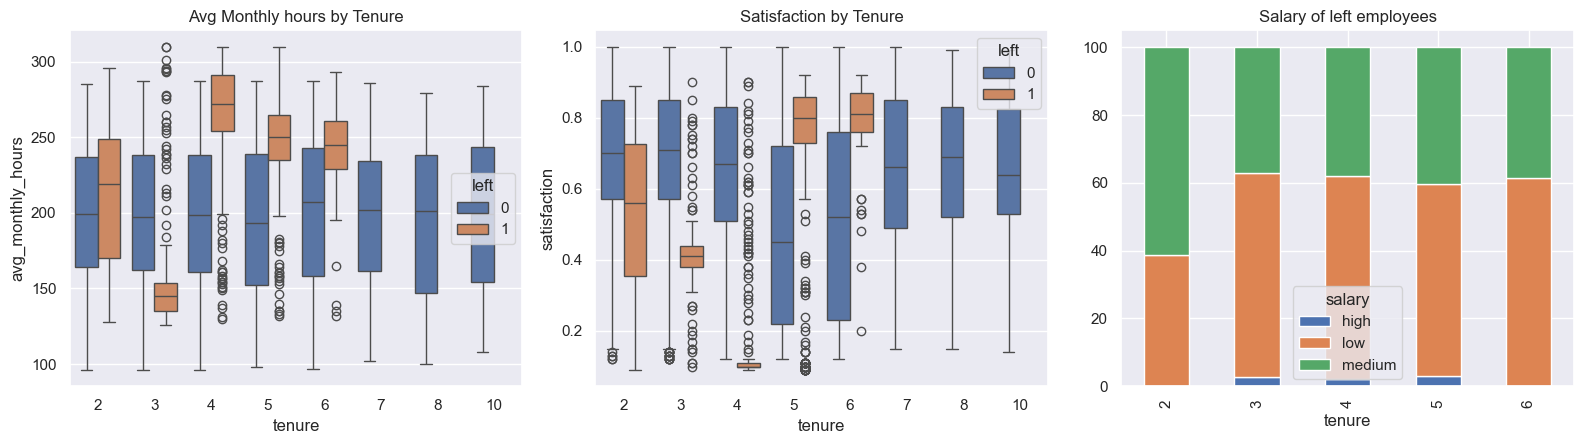

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

sns.boxplot(ax=axes[0], data=df, x='tenure', y='avg_monthly_hours', hue='left')
axes[0].set_title('Avg Monthly hours by Tenure')

sns.boxplot(ax=axes[1], data=df, x='tenure', y='satisfaction', hue='left')
axes[1].set_title('Satisfaction by Tenure')

percentage_left = (df_left.groupby('tenure')['salary'].value_counts(normalize=True) * 100).unstack().fillna(0)
percentage_left.plot(kind='bar', stacked=True, ax=axes[2])

axes[2].set_title('Salary of left employees')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

::: {.callout-tip}
### Finding 8

- Employees who have been with the company for ***over 7 years are likely to stay***. There are 282 such employees as calculated above.
- Employees who have been with the company for ***4, 5, or 6 years and have an average monthly hour higher than their peers in the same years are likely to leave***.
    - Employees who leave in years ***5 and 6 tend to express higher dissatisfaction*** compared to those who stay.
- Further examination of the salary of left employees reveals that there are no employees with high salaries in year 6, and the majority receive ***low to medium salaries in years 4 and 5***.

:::

Visualise group of *left employee* to view the monthly working hours and promotion they have received 

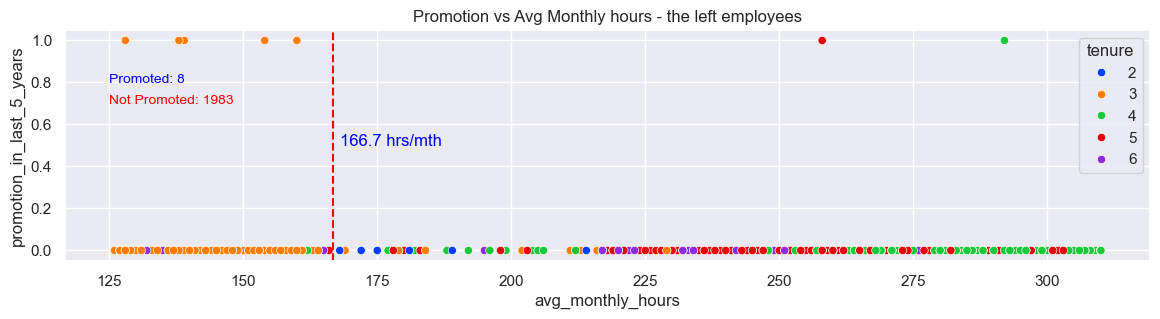

In [25]:
# evaluation vs avg_monthly_hours
plt.figure(figsize=(14,3 ))

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
# fig.suptitle('Scattlot of the left employees', fontsize=16)

sns.scatterplot(data=df_left, x='avg_monthly_hours', y='promotion_in_last_5_years', hue = 'tenure',
               palette='bright')

# Calculate and annotate the number of promoted and not promoted employees
promoted_count = df_left[df_left['promotion_in_last_5_years'] == 1].shape[0]
not_promoted_count = df_left[df_left['promotion_in_last_5_years'] == 0].shape[0]

plt.annotate(f'Promoted: {promoted_count}', (125, 0.8), color='blue', fontsize=10)
plt.annotate(f'Not Promoted: {not_promoted_count}', (125, 0.7), color='red', fontsize=10)

plt.title('Promotion vs Avg Monthly hours - the left employees')
plt.axvline(x=166.7, color='red', linestyle='--')
plt.text(168, 0.5, '166.7 hrs/mth', color='blue', fontsize=12)

plt.show()

::: {.callout-tip}
### Finding 9
Among the employees who have left the company:

- Only 8 were promoted in the last 5 years.
- Employees who have ***worked for 4 to 5 years, are overworked, and have not received a promotion are more likely to leave***.

These employees have been working hard but have not been adequately recognized or rewarded, which could be a significant factor in their decision to leave the company.
:::

#### Correlation Analysis: 

Calculate correlation coefficients between numerical variables to identify linear relationships.

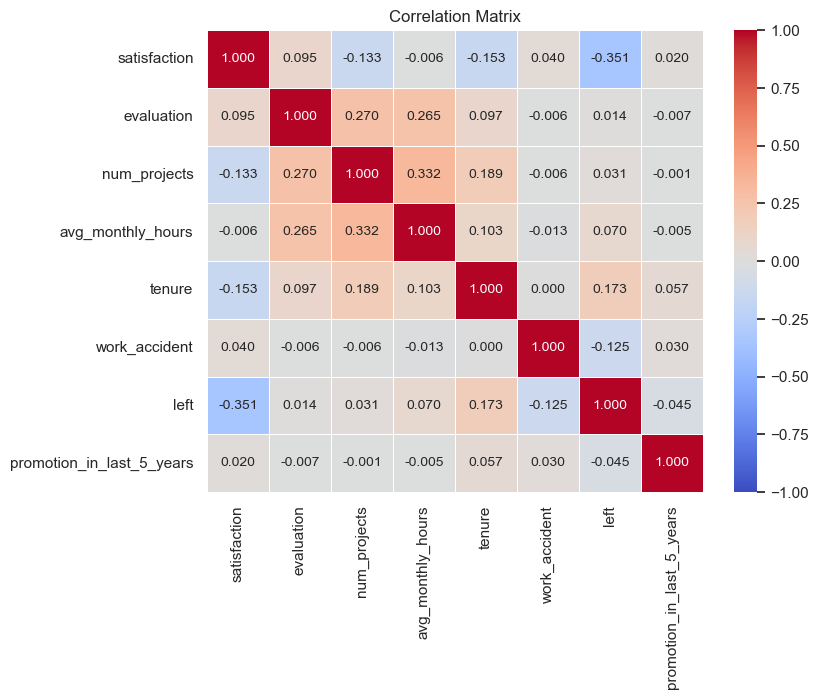

In [26]:
# Calculate correlation matrix
correlation_matrix = df.select_dtypes(include=['number']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 6))

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5, vmin=-1, vmax=1, 
            annot_kws={"fontsize":10})

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()

::: {.callout-tip}
### Finding 10

From the correlation matrix provided, several insights can be drawn:

- **Satisfaction and Attrition**: There is a moderately strong negative correlation (-0.35) between satisfaction and the likelihood of an employee leaving the company. This implies that as satisfaction decreases, the probability of an employee leaving increases.
- **Evaluation**: There is a very weak positive correlation (0.01) between evaluation scores and the likelihood of an employee leaving. This suggests that there is not a strong linear relationship between performance evaluation scores and attrition.
- **Number of Projects**: There is a weak positive correlation (0.03) between the number of projects an employee is involved in and the likelihood of them leaving. This implies that there may be a slight tendency for employees with more projects to leave, but the effect is not very strong.
- **Average Monthly Hours**: There is a weak positive correlation (0.07) between the average monthly hours worked and the likelihood of an employee leaving. This suggests that employees who work longer hours might be slightly more likely to leave, but again, the effect is not very strong.
- **Tenure**: There is a moderate positive correlation (0.17) between the number of years an employee has been with the company and the likelihood of them leaving. This indicates that longer-tenured employees are somewhat more likely to leave compared to newer employees.
- **Work Accident and Promotion**: There are very weak correlations between work accidents, promotions in the last 5 years, and the likelihood of an employee leaving (-0.13 and -0.04, respectively). These correlations suggest that these factors have minimal linear relationships with attrition.

:::

#### Findings Summary

## Model Selection, Training, and Evaluation:

Choose appropriate models, train them on the data, and evaluate their performance using relevant metrics.

### Identify the type of prediction and select approriate model

- Our goal in this task is to predict whether an employee will leave the company or not, which is a categorical variable. So, this is a binary classification prediction task.
- Since the variable we will predict (whether an employee leaves or stays) is categorical and binary, we can use logistic regression or tree-based machine learning models for this classification task.

### Modeling Approach A: Logistic Regression

#### Encode variables

We should encode categorical variables before splitting data for modeling. There are 2 variables to convert: `department` and `salary`.

- Convert `salary` to ordinay variable,`department` to dummy variables, the display the first 5 rows:

In [27]:
# Convert salary to ordinay variable 
# Define the mapping dictionary
df_encoded = df.copy()
salary_mapping = {'low': 0, 'medium': 1, 'high': 2}

# Apply the mapping to the 'salary' column
df_encoded['salary'] = df_encoded['salary'].map(salary_mapping)

In [28]:
# Convert department to dummy variables
df_encoded = pd.get_dummies(df_encoded, columns=['department'], drop_first=False)
df_encoded.head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,left,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.380,0.530,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.800,0.860,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.110,0.880,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.720,0.870,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.370,0.520,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


#### Remove outliers

- As identified above, outliers in the `tenure` feature have values equal to or greater than **6**. Let's check the proportion of `tenure`:

In [29]:
# Checking the proportion of tenure.
# note the the upper limit is 5.5
df['tenure'].value_counts(normalize=True).sort_index()

tenure
2    0.243
3    0.433
4    0.167
5    0.089
6    0.045
7    0.008
8    0.007
10   0.009
Name: proportion, dtype: float64

::: {.callout-note}

- Although Logistic regression models are sensitive to outliers, with a large sample size of 11,991 (after removing duplicate), they are generally robust.
- The proportion of observations with `tenure` higher than 5.5 (values of 6, 7, 8, and 10) is 0.069, suggesting that removing those outliers ***could have an impact***.
    - However, another statistic shows that employees with a `tenure` *equal and above 7 years* ***stayed with the company***. For the purpose of analyzing attrition, we can exclude this group (the proportion of this group is 2.4%).
:::

- Create subset to exclude tenure higher than 6 years

In [30]:
# Create subset to exclude tenure higher than 6 years
df1 = df_encoded[df_encoded['tenure'] < 6]
df1

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,left,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.380,0.530,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.110,0.880,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.720,0.870,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.370,0.520,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.410,0.500,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11985,0.720,0.640,4,192,3,0,0,0,1,False,False,False,False,False,False,False,True,False,False
11986,0.480,0.500,5,142,4,0,0,0,1,True,False,False,False,False,False,False,False,False,False
11987,0.190,0.790,4,229,4,0,0,0,1,False,False,False,False,False,False,True,False,False,False
11992,0.620,0.850,3,237,3,1,0,0,1,True,False,False,False,False,False,False,False,False,False


#### Select variables

We will:

- Select outcome variable : `left`
- Select features: other variables except `left`.
- Then display few rows of features dataframe

In [31]:
# Select outcome variable
Y = df1['left']

In [32]:
# Select features
X = df1.drop(columns='left', axis=1)

# Display first few rows of features dataframe
X.head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.380,0.530,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.110,0.880,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.720,0.870,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.370,0.520,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.410,0.500,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


#### Train-Test split

- Split the data into training and testing sets.

In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify = Y, random_state=42)

- Confirm that the dimensions of the training and testing sets are in alignment, by:
    - Review shape of training and testing set, and
    - Display few rows of training set

In [34]:
# Get shape of each training and testing set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8375, 18) (2792, 18) (8375,) (2792,)
(8375, 18) (2792, 18) (8375,) (2792,)


In [35]:
# Display first few rows of `X_train`
X_train.head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
9784,0.430,0.810,3,102,3,0,0,1,False,False,False,False,False,False,False,True,False,False
6535,0.740,0.680,3,206,2,1,0,1,False,False,False,False,False,False,False,False,True,False
5217,0.870,0.500,4,267,2,1,0,1,False,False,True,False,False,False,False,False,False,False
8421,0.610,0.560,2,123,2,0,0,1,False,False,False,False,False,False,False,True,False,False
6134,0.650,0.790,4,196,2,0,0,1,False,False,True,False,False,False,False,False,False,False


#### Model build

- First, construct a logistic regression model and fit it to the training set

In [36]:
# Construct a logistic regression model and fit it to the training set
log_reg = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

- Test the logistic regression model. Use the model to make predictions on the encoded testing set.

In [37]:
# Use the logistic regression model to get predictions on the encoded testing set
y_pred = log_reg.predict(X_test)

#### Visualize model results

- Create a confusion matrix to visualize the results of the logistic regression model.

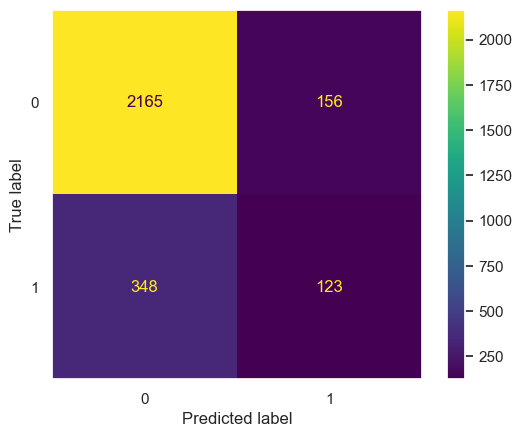

In [38]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_reg.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=log_reg.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')
plt.grid(False)

# Display plot
plt.show()

Interpretation from upper-left to bottom-right: 

- **True Negatives (TN)**: (2165) Employees correctly predicted to stay with the company. These are the employees the model identified as likely to stay, and they did stay.
- **False Positives (FP)**: (156) Employees incorrectly predicted to leave the company. These are the employees the model identified as likely to leave, but they actually stayed.
- **False Negatives (FN)**: (348) Employees incorrectly predicted to stay with the company. These are the employees the model identified as likely to stay, but they actually left.
- **True Positives (TP)**: (123) Employees correctly predicted to leave the company. These are the employees the model identified as likely to leave, and they indeed left.

- Create a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

In [39]:
accuracy_sc = accuracy_score(y_test, y_pred)
precision_sc = precision_score(y_test, y_pred)
recall_sc = recall_score(y_test, y_pred)
f1_sc = f1_score(y_test, y_pred)
auc_sc = roc_auc_score(y_test, y_pred)

print("Classification Report:\n")
# Print the results
print('Accuracy: %.3f' % accuracy_sc)
print('Precision: %.3f' % precision_sc)
print('Recall: %.3f' % recall_sc)
print('F1 Score: %.3f' % f1_sc)
print('AUC: %.3f' % auc_sc)

Classification Report:

Accuracy: 0.819
Precision: 0.441
Recall: 0.261
F1 Score: 0.328
AUC: 0.597
Classification Report:

Accuracy: 0.819
Precision: 0.441
Recall: 0.261
F1 Score: 0.328
AUC: 0.597


- Or use `classification_report()` function:

In [40]:
# You can also use classification_report for a detailed report
target_names = ['Predicted would not leave', 'Predicted would leave']
report = classification_report(y_test, y_pred,target_names=target_names)

accuracy = accuracy_score(y_test, y_pred)

# Print the classification report and accuracy
bold_text = '\033[1m'
reset_format = '\033[0m'

print(f'{bold_text}Classification Report:\n{reset_format}{report}')
print(f'{bold_text}Accuracy:{reset_format} %.3f' % accuracy)

Classification Report:
                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792

Accuracy: 0.819
Classification Report:
                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792

Accuracy: 0.819


- Create a table for further comparison:

In [41]:
# Create comparing table
lr_metrics = pd.DataFrame({
    'Model': "Logistics Regression on Test",
    'Accuracy': [accuracy_sc],
    'Precision': [precision_sc],
    'Recall': [recall_sc],
    'F1': [f1_sc],
    'AUC' : [auc_sc]
})
lr_metrics

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistics Regression on Test,0.819,0.441,0.261,0.328,0.597


::: {.callout-tip}
## Finding

Given the objective of predicting whether someone would leave, the classification report provides valuable insights into how well the model performs in this task:

- **Precision**:
    - For the class "Predicted would not leave," the precision is relatively high (0.86), indicating that when the model predicts someone would not leave, it's correct around 86% of the time. This suggests that the model is good at identifying individuals who are likely to stay.
    - However, for the class "Predicted would leave," the precision is lower (0.44), meaning that the model is less accurate when predicting individuals who are likely to leave. This suggests room for improvement in identifying individuals who are likely to leave.
- **Recall**:
    - The recall for the class "Predicted would not leave" is high (0.93), indicating that the model effectively captures the majority of individuals who actually would not leave.
    - On the other hand, the recall for the class "Predicted would leave" is low (0.26), suggesting that the model misses a significant portion of individuals who would actually leave.
- **F1-score**:
    - The F1-score balances precision and recall. It's high for the class "Predicted would not leave" (0.90), reflecting a good balance between precision and recall for this class.
    - However, the F1-score is low for the class "Predicted would leave" (0.33), indicating a trade-off between precision and recall, possibly due to the low recall for this class.
- **Accuracy**:
    - The overall accuracy of the model is 0.82, indicating that around 82% of the predictions made by the model are correct. While accuracy is important, it may not be the best metric for imbalanced datasets, like in this case, where the classes might not be evenly distributed.

In summary, while the model performs ***well in predicting individuals who are likely to stay, it struggles with identifying individuals who are likely to leave***.

- To improve the model's performance in predicting individuals who would leave, we may want to focus on increasing recall for the "Predicted would leave" class, possibly through techniques such as feature engineering, model tuning, or addressing class imbalance if present. 
- Additionally, exploring different evaluation metrics tailored to the specific business objective, such as cost-sensitive evaluation metrics, may also be beneficial.
:::


### Modeling Approach B : Tree-based Model

We will build Decision Tree, Random Forest and XGBoost in this section.

#### Train-test split

- First we will select outcome variable, features and split Training and Testing

In [42]:
# Select outcome variable
Y = df_encoded['left']

# Select features
X = df_encoded.drop(columns='left')

# Display first few rows of features dataframe
X.head()

,satisfaction,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.380,0.530,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.800,0.860,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.110,0.880,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.720,0.870,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.370,0.520,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [43]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify = Y,
                                                    random_state=42)

In [44]:
#| echo: false
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                 }

  # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

  # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                          'AUC': [auc]
                         })

    return table

#### Decision Tree model

- Construct the decision tree model, fit model to training data, predict on test data

In [45]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

- Print out the decision tree model's accuracy, precision, recall, and F1 score.

In [46]:
# Generate performance metrics
accuracy_sc = accuracy_score(y_test, dt_pred)
precision_sc = precision_score(y_test, dt_pred)
recall_sc = recall_score(y_test, dt_pred)
f1_sc = f1_score(y_test, dt_pred)
auc_sc = roc_auc_score(y_test, dt_pred)

print("Classification Report:\n")
# Print the results
print("Accuracy:", "%.3f" % accuracy_sc)
print("Precision:", "%.3f" % precision_sc)
print("Recall:", "%.3f" % recall_sc)
print("F1 Score:", "%.3f" % f1_sc)
print("AUC:", "%.3f" % auc_sc)

Classification Report:

Accuracy: 0.969
Precision: 0.898
Recall: 0.916
F1 Score: 0.907
AUC: 0.947
Classification Report:

Accuracy: 0.969
Precision: 0.898
Recall: 0.916
F1 Score: 0.907
AUC: 0.947


- Create comparing table

In [47]:
# Create comparing table
dt_metrics = pd.DataFrame({
    'Model': "Decision Tree on Test",
    'Accuracy': [accuracy_sc],
    'Precision': [precision_sc],
    'Recall': [recall_sc],
    'F1': [f1_sc],
    'AUC' : [auc_sc]
})
dt_metrics

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree on Test,0.969,0.898,0.916,0.907,0.947


## Hyperparameter Tuning and Validation:

Fine-tune model parameters and validate the final model's performance using separate validation datasets or cross-validation.

### Tuning with Cross Validation

#### Decision Tree - with CV

- In this round we will construct a decision tree model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [48]:
# Instantiate the Decision Tree classifier
dt = DecisionTreeClassifier(random_state = 0)

# Create a dictionary of hyperparameters to tune

cv_params = {'max_depth': [5, 7, 9, None],
#            #  'max_features': 'auto'
#             'max_samples': [0.7],
             'min_samples_leaf': [2,4,6],
             'min_samples_split': [2,3,5,7]
             }


# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the GridSearchCV object
dt_cv = GridSearchCV(dt, cv_params, scoring=scoring, cv=4, refit='roc_auc')

- Now fit the model to the training data.

In [49]:
%%time
# Fit the model
dt_cv.fit(X_train, y_train)

CPU times: user 6.52 s, sys: 138 ms, total: 6.66 s
Wall time: 7.2 s
CPU times: user 6.52 s, sys: 138 ms, total: 6.66 s
Wall time: 7.2 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, 9, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 3, 5, 7]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

- Examine the best average score across all the validation folds.

In [50]:
# Examine best score
dt_cv.best_score_

0.9758070264225602

- Examine the best combination of hyperparameters.

In [51]:
# Examine best hyperparameter combo
dt_cv.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

- Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

- Pass the GridSearch object to the make_results() function

In [52]:
dt_results = make_results("Decision Tree CV",dt_cv,'auc')
dt_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976


#### Random Forest - with CV

- Construct a random forest model and set up cross-validated grid-search to exhuastively search for the best model parameters.

In [53]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2,4,6, None],
             'max_features': [0.6, 1.0],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,5],
             'n_estimators': [50,75,100],
             }

# cv_params = {'max_depth': [3,5, None], 
#              'max_features': [1.0],
#              'max_samples': [0.7, 1.0],
#              'min_samples_leaf': [1,2,3],
#              'min_samples_split': [2,3,4],
#              'n_estimators': [300, 500],
#              }  

# cv_params = {'max_depth': [None],
#              'max_features': [1.0],
#              'max_samples': [1.0],
#              'min_samples_leaf': [2],
#              'min_samples_split': [2],
#              'n_estimators': [300],
#              }

# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [54]:
%%time
# Fit the model.
rf_cv.fit(X_train, y_train)

CPU times: user 8min 30s, sys: 9.51 s, total: 8min 40s
Wall time: 9min 39s
CPU times: user 8min 30s, sys: 9.51 s, total: 8min 40s
Wall time: 9min 39s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, None],
                         'max_features': [0.6, 1.0], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 75, 100]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

- Examine the best average score across all the validation folds.

In [55]:
# Examine best score
rf_cv.best_score_

0.9820281400983498

- Examine the best combination of hyperparameters.

In [56]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': 6,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

- Pass the GridSearch object to the make_results() function.

In [57]:
rf_results = make_results("Random Forest CV",rf_cv,'auc')
rf_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982


#### XGBoost - with CV

Try whether to improve our scores using an XGBoost model.

In [58]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [200, 300]
             }

# cv_params = {'max_depth': [6, 12],
#              'min_child_weight': [3, 5],
#              'learning_rate': [0.01, 0.1],
#              'n_estimators': [300]
#              }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']


# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='roc_auc')

- Now fit the model to the X_train and y_train data.

In [59]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 2min 59s, sys: 8.56 s, total: 3min 8s
Wall time: 1min 28s
CPU times: user 2min 59s, sys: 8.56 s, total: 3min 8s
Wall time: 1min 28s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [200, 300]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

- Get the best score and best parameter from this XGBoost model.

In [60]:
# Examine best score
xgb_cv.best_score_

0.9838485154334704

In [61]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200}

- Use the make_results() function to output all of the scores of XGBoost model.

In [62]:
# Call 'make_results()' on the GridSearch object
xgb_results = make_results('XGBoost CV',xgb_cv,'auc')
xgb_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost CV,0.981,0.969,0.915,0.941,0.984


### Evaluating model's performance

Evaluating models by comparing the perfomance's scores : Accuracy, Precision, Recall, F1 and ROC-AUC

In [63]:
results = pd.concat([dt_metrics,dt_results, rf_results, xgb_results])
results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree on Test,0.969,0.898,0.916,0.907,0.947
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982
0,XGBoost CV,0.981,0.969,0.915,0.941,0.984


::: {.callout-tip}
### Finding
Comparing these models, we observe:

- **Decision Tree** demonstrates good performance across all metrics, with particularly high recall and AUC indicating its ability to correctly identify leaving case).
- **Decision Tree with Cross-Validation** Cross-validation appears to improve the performance slightly compared to the decision tree model tested on a single holdout set, with higher precision and F1 score.
- **Random Forest with Cross-Validation** Random Forest CV generally performs well with high accuracy and AUC. However, it seems to have a slightly lower recall compared to the Decision Tree CV.
- **XGBoost with Cross-Validation** XGBoost, a gradient boosting algorithm, demonstrates the highest overall performance with the highest accuracy, precision, and F1 score among all models. However, its recall is slightly lower compared to the Decision Tree CV.
 
XGBoost CV shows the best overall performance across all metrics, followed closely by Random Forest CV and Decision Tree CV.
:::

Next, we will evaluate the Random Forest and XGBoost on the test set to verify the champion.

### Evaluating perfomance's metrics on test set

Define a function that gets all the scores from a model's predictions.

In [64]:
# Define a function that gets all the scores from a model's predictions.
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of accuracy, precision, recall, f1, and AUC scores for your model
    '''
     
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)
    auc = roc_auc_score(y_test_data, preds)

    table = pd.DataFrame({'Model': [model_name],
                          'Accuracy': [accuracy],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                          'AUC': [auc]                          
                          })
    
    return table

#### Random Forest CV on test set

- Get predictions on test data, and
- Get test score for RF model

In [65]:
# Get predictions on test data
rf_pred = rf_cv.best_estimator_.predict(X_test)

In [66]:
# Get test score for RF model
rf_scores = get_test_scores('RF on test', rf_pred, y_test)
rf_scores

,Model,Accuracy,Precision,Recall,F1,AUC
0,RF on test,0.984,0.979,0.922,0.949,0.959


In [67]:
# Create classification report for Random Forest CV model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, rf_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.98      1.00      0.99      2500
    Predicted would leave       0.98      0.92      0.95       498

                 accuracy                           0.98      2998
                macro avg       0.98      0.96      0.97      2998
             weighted avg       0.98      0.98      0.98      2998

                           precision    recall  f1-score   support

Predicted would not leave       0.98      1.00      0.99      2500
    Predicted would leave       0.98      0.92      0.95       498

                 accuracy                           0.98      2998
                macro avg       0.98      0.96      0.97      2998
             weighted avg       0.98      0.98      0.98      2998



#### XGBoost CV on test set

- Get predictions on test data, and
- Get test score for XGBoost model

In [68]:
# Get predictions on test data
xgb_pred = xgb_cv.best_estimator_.predict(X_test)

In [69]:
# Get test scores for XGBoost model
xgb_scores = get_test_scores('XGBoost on test', xgb_pred, y_test)
xgb_scores

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost on test,0.983,0.971,0.928,0.949,0.961


In [70]:
# Create classification report for XGBoost CV model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, xgb_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.99      0.99      0.99      2500
    Predicted would leave       0.97      0.93      0.95       498

                 accuracy                           0.98      2998
                macro avg       0.98      0.96      0.97      2998
             weighted avg       0.98      0.98      0.98      2998

                           precision    recall  f1-score   support

Predicted would not leave       0.99      0.99      0.99      2500
    Predicted would leave       0.97      0.93      0.95       498

                 accuracy                           0.98      2998
                macro avg       0.98      0.96      0.97      2998
             weighted avg       0.98      0.98      0.98      2998



#### Test scores from 2 models

In [71]:
# Append to the results table
test_scores = pd.concat([rf_scores,xgb_scores])
test_scores

,Model,Accuracy,Precision,Recall,F1,AUC
0,RF on test,0.984,0.979,0.922,0.949,0.959
0,XGBoost on test,0.983,0.971,0.928,0.949,0.961


#### Include the previous results

In [72]:
test = pd.concat([results,rf_scores,xgb_scores])
test

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree on Test,0.969,0.898,0.916,0.907,0.947
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982
0,XGBoost CV,0.981,0.969,0.915,0.941,0.984
0,RF on test,0.984,0.979,0.922,0.949,0.959
0,XGBoost on test,0.983,0.971,0.928,0.949,0.961


::: {.callout-tip}
## Finding

Comparing the results:

- **Accuracy:** Random Forest with CV slightly outperforms XGBoost with CV by a margin of 0.001.
- **Precision:** Random Forest with CV achieves higher precision 0.979 compared to XGBoost with CV 0.971, indicating better identification of true positives with fewer false positives.
- **Recall:** XGBoost with CV has a higher recall 0.928 compared to Random Forest with CV 0.922, indicating its ability to capture ***more true positives while possibly accepting more false positives***.
- **F1 Score:** Both models have the same F1 score of 0.949, which is the harmonic mean of precision and recall. This suggests that both models achieve a good balance between precision and recall.
- **AUC:** XGBoost has a slightly higher AUC of 0.961, compared to Random Forest's AUC of 0.959. AUC represents the model's ability to distinguish between positive and negative instances. In this case, XGBoost has a slightly better ability to do so..

Both Random Forest and XGBoost models perform exceptionally well in predicting employee attrition on the test set. Random Forest performs slightly better in terms of accuracy, precision, and AUC, while XGBoost shows a slightly higher recall.

:::

#### Confusion matrix on test set

- Generate confusion matrix for Random Forest and XGBoost on test set

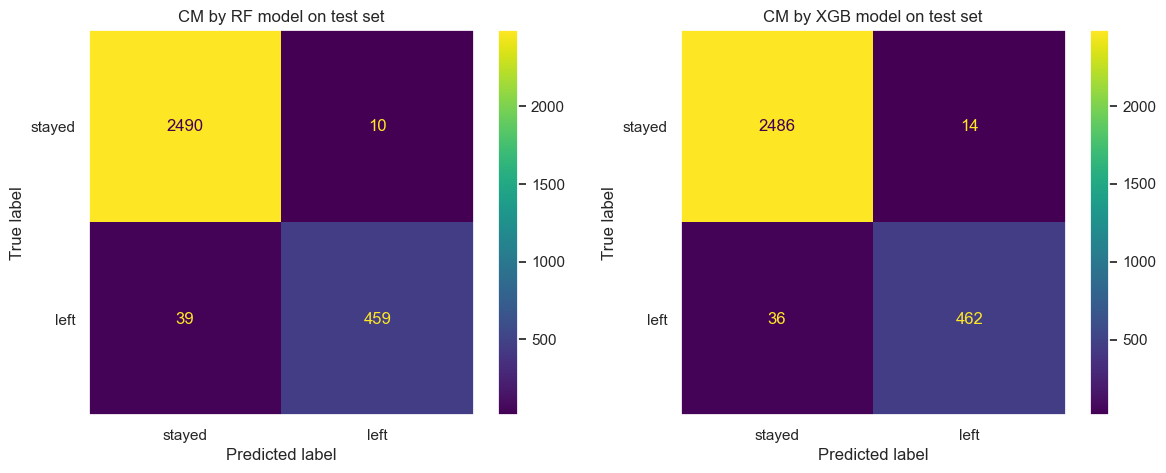

In [73]:
target_labels = ['stayed', 'left']
# Generate array of values for confusion matrix

cm_rf = confusion_matrix(y_test, rf_pred, labels=xgb_cv.classes_)
cm_xgb = confusion_matrix(y_test, xgb_pred, labels=xgb_cv.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Plot confusion matrix
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                             display_labels=target_labels)

disp_rf.plot(ax=axes[0],values_format='')
axes[0].set_title('CM by RF model on test set')
axes[0].grid(False)

# Plot confusion matrix XGB
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                             display_labels=target_labels)
disp_xgb.plot(ax=axes[1],values_format='')
axes[1].set_title('CM by XGB model on test set')
axes[1].grid(False)

plt.show()

#### Feature importance

- Visualize feature importance for 2 models:

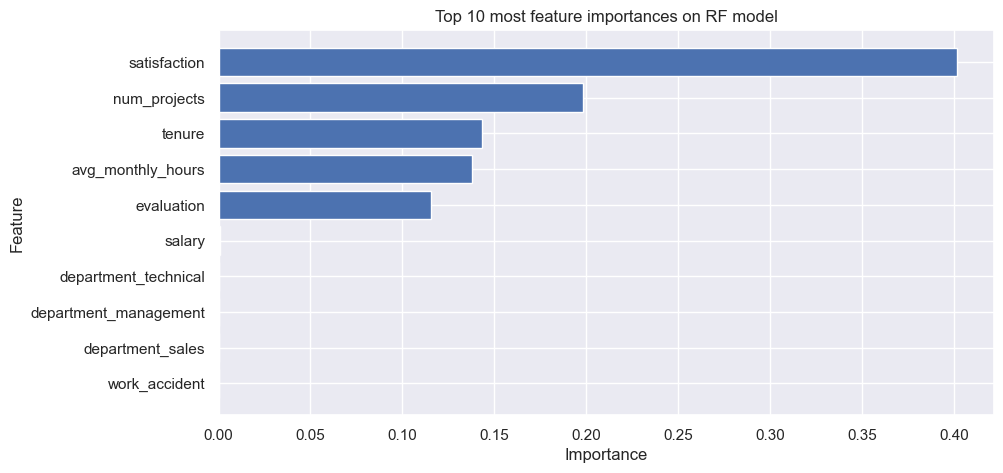

In [74]:
# Get feature importances
feature_importances = rf_cv.best_estimator_.feature_importances_

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 most feature importances on RF model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

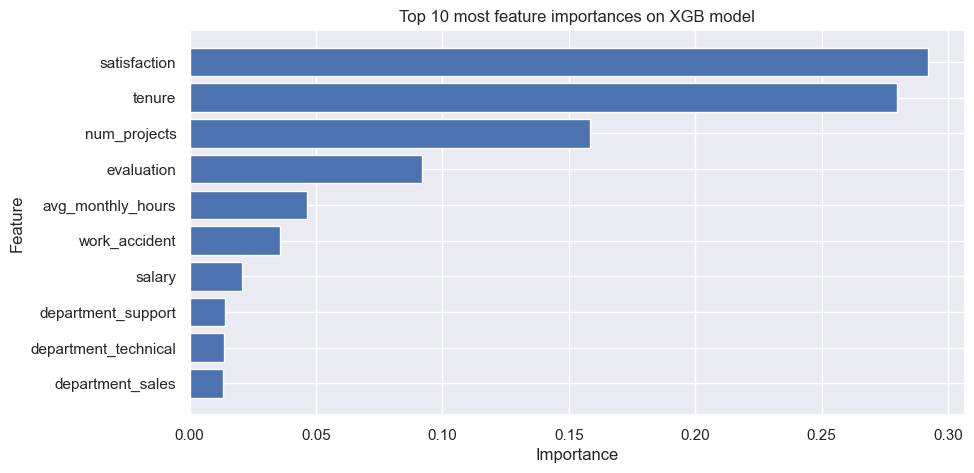

In [75]:
# Get feature importances
feature_importances = xgb_cv.best_estimator_.feature_importances_

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 most feature importances on XGB model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

The most important features from both Random Forest and XGBoost lists are `satisfaction`, `tenure`, `num_projects`, `evaluation`, and `avg_monthly_hours`, which corroborate our insights from the EDA stage as follows:

- Employees with ***satisfaction levels below 0.12 are likely to leave***.
- Employees who have been ***with the company for 7 years or more are likely to stay.***
- Employees who work ***on 7 projects are likely to leave.***
- Employees who work ***on 4, 5, or 6 projects and have higher-than-average monthly hours are likely to leave.***"

### Improvement with Feature Engineering

#### Feature Engineering

Althought we have good performance metrics with both Random Forest and XGBoost on test set, it would be concern about those high evaluation scores:

- Regarding high evaluation scores: It's advisable to approach high evaluation scores with caution. There may be reasons to doubt their accuracy, particularly due to the potential occurrence of data leakage.
- Data Leakage happens when information that shouldn't influence model training is inadvertently included. This can lead to inflated performance metrics during evaluation if the model unintentionally learns from data it shouldn't have access to.
- Possible Sources of Data Leakage:
     - Satisfaction Levels: Not all employees might have their satisfaction levels reported, which could affect model training and evaluation.
     - Average Monthly Hours: This data might inadvertently include information about employees who are likely to quit or be fired, potentially leading to biased model predictions.
- Strategy for Improvement:
    - Utilizing Feature Engineering: Employing feature engineering techniques can help create more informative features for the models.
    - Removing Satisfaction Level: Since satisfaction levels might not be consistently reported, it might be prudent to exclude this variable from the model.
    - Introducing a New Feature: A new binary feature called **`overworked`** could be introduced, likely based on employees' average monthly hours, to capture whether an employee is overburdened with work.


- First, copy the encoded `df` to new `df2` 

In [76]:
# Copy encoded df to new df2
df2 = df_encoded.copy()

- Drop `satisfaction` level

In [77]:
# Drop satisfaction level
df2 = df2.drop('satisfaction', axis = 1)
df2.head()

,evaluation,num_projects,avg_monthly_hours,tenure,work_accident,left,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.530,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.860,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.880,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.870,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.520,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


- Create a new feature: **`overworked`** :
    - Considering that individuals typically work 50 weeks per year, 5 days per week, and 8 hours per day, the average monthly working hours amount to 166.7 hours.
    
    - We'll define individuals who work over 5% of this average monthly hour as **`overworked`**. Therefore, the threshold for being classified as overworked will be 166.7 * 1.05 = 175 hours per month."

In [78]:
# Create new feature overworked
df2['overworked'] = df2['avg_monthly_hours']

# Replace overworked = 1 when it is higher than 175
df2['overworked'] = np.where(df2['overworked']>175,1,0)

# Drop 'avg_monthly_hours'
df2 = df2.drop('avg_monthly_hours',axis=1)
df2.head()

,evaluation,num_projects,tenure,work_accident,left,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.530,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.860,5,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.880,7,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.870,5,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.520,2,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


- We now select features, outcome and split into training and testting set from `df2`

In [79]:
# Select outcome variable
Y = df2['left']

# Select features
X = df2.drop(columns='left', axis=1)

#### Train-test split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify = Y, random_state=42)

# Get shape of each training and testing set
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Display first few rows of `X_train`
X_train.head()

(8993, 17) (2998, 17) (8993,) (2998,)
(8993, 17) (2998, 17) (8993,) (2998,)


,evaluation,num_projects,tenure,work_accident,promotion_in_last_5_years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
984,0.860,5,5,0,0,0,True,False,False,False,False,False,False,False,False,False,1
610,0.950,7,4,0,0,1,False,False,False,False,False,True,False,False,False,False,1
7033,0.610,3,4,0,0,1,False,False,False,False,False,False,False,True,False,False,0
6411,0.750,4,2,0,0,1,False,False,False,False,False,False,False,True,False,False,1
8388,0.790,3,4,0,0,1,False,False,False,False,False,False,True,False,False,False,1


#### Construct Models after Feature Engineering

In this second round, we will construct three models again: Decision Tree, Random Forest, and XGBoost, and then evaluate their performance..

##### Decision Tree - round 2

- Construct Decision Tree model

In [80]:
#: echo:false
# Instantiate the Decision Tree classifier
dt2 = DecisionTreeClassifier(random_state = 0)

# Create a dictionary of hyperparameters to tune

cv_params = {'max_depth': [5, 7, 9, None],
#            #  'max_features': 'auto'
#             'max_samples': [0.7],
             'min_samples_leaf': [2,4,6],
             'min_samples_split': [2,3,5,7]
             }


# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the GridSearchCV object
dt2_cv = GridSearchCV(dt2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [81]:
#| echo: false
%%time
# Fit the model
dt2_cv.fit(X_train, y_train)

CPU times: user 7.23 s, sys: 221 ms, total: 7.45 s
Wall time: 10.5 s
CPU times: user 7.23 s, sys: 221 ms, total: 7.45 s
Wall time: 10.5 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, 9, None],
                         'min_samples_leaf': [2, 4, 6],
                         'min_samples_split': [2, 3, 5, 7]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [82]:
#| include: false
# Examine best score
dt2_cv.best_score_

# Examine best hyperparameter combo
dt2_cv.best_params_

{'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}

In [83]:
dt2_results = make_results("Decision Tree CV",dt_cv,'auc')
dt2_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976


##### Random Forest - round 2

- Construct Random Forest model

In [84]:
#| echo: false
# Instantiate the random forest classifier
rf2 = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [2,4,6, None],
             'max_features': [0.6, 1.0],
            #  'max_features': 'auto'
             'max_samples': [0.7],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,5],
             'n_estimators': [50,75,100],
             }


# Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate the GridSearchCV object
rf2_cv = GridSearchCV(rf2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [85]:
#| echo: false
%%time
# Fit the model.
rf2_cv.fit(X_train, y_train)

CPU times: user 6min 46s, sys: 9.47 s, total: 6min 55s
Wall time: 8min 21s
CPU times: user 6min 46s, sys: 9.47 s, total: 6min 55s
Wall time: 8min 21s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 4, 6, None],
                         'max_features': [0.6, 1.0], 'max_samples': [0.7],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [50, 75, 100]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [86]:
#| include: false
# Examine best score
rf2_cv.best_score_

# Examine best hyperparameter combo
rf2_cv.best_params_

{'max_depth': 6,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 75}

In [87]:
rf2_results = make_results("Random Forest CV",rf_cv,'auc')
rf2_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982


##### XGBoost - round 2

- Construct XGBoost model

In [88]:
#| echo: false
# 1. Instantiate the XGBoost classifier
xgb2 = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6,8,12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [200, 300]
             }

# cv_params = {'max_depth': [6, 12],
#              'min_child_weight': [3, 5],
#              'learning_rate': [0.01, 0.1],
#              'n_estimators': [300]
#              }

# 3. Define a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1','roc_auc']


# 4. Instantiate the GridSearchCV object
xgb2_cv = GridSearchCV(xgb2, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [89]:
#: echo: false
%%time
xgb2_cv.fit(X_train, y_train)

CPU times: user 2min 8s, sys: 2.98 s, total: 2min 11s
Wall time: 37.6 s
CPU times: user 2min 8s, sys: 2.98 s, total: 2min 11s
Wall time: 37.6 s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [200, 300]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [90]:
#| include: false
# Examine best score
xgb2_cv.best_score_

# Examine best parameters
xgb2_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 5,
 'n_estimators': 200}

In [91]:
# Call 'make_results()' on the GridSearch object
xgb2_results = make_results('XGBoost CV',xgb2_cv,'auc')
xgb2_results

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost CV,0.963,0.900,0.871,0.885,0.972


- Compare results for the second round from 3 models

In [92]:
results2 = pd.concat([dt2_results,rf2_results,xgb2_results])
results2

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982
0,XGBoost CV,0.963,0.900,0.871,0.885,0.972


#### Get the score on the test set

##### Random Forest on test set

In [93]:
#| echo: false
# Get predictions on test data
rf2_pred = rf2_cv.best_estimator_.predict(X_test)

# Get test score for RF model
rf2_scores = get_test_scores('RF on test', rf2_pred, y_test)
rf2_scores

,Model,Accuracy,Precision,Recall,F1,AUC
0,RF on test,0.969,0.903,0.912,0.907,0.946


##### XGBoost on test set

In [94]:
# Get predictions on test data
xgb2_pred = xgb2_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb2_scores = get_test_scores('XGBoost on test', xgb2_pred, y_test)
xgb2_scores

,Model,Accuracy,Precision,Recall,F1,AUC
0,XGBoost on test,0.966,0.901,0.892,0.896,0.936


#### The Results after Feature Engineering

- The results including performance metrics on test set:

In [95]:
#| echo: false
result2 = pd.concat([results2,rf2_scores,xgb2_scores])
result2

,Model,Accuracy,Precision,Recall,F1,AUC
0,Decision Tree CV,0.978,0.950,0.918,0.934,0.976
0,Random Forest CV,0.980,0.966,0.911,0.938,0.982
0,XGBoost CV,0.963,0.900,0.871,0.885,0.972
0,RF on test,0.969,0.903,0.912,0.907,0.946
0,XGBoost on test,0.966,0.901,0.892,0.896,0.936


After feature enginerring, from these metrics, we can observe:

- Random Forest CV has the highest accuracy, precision, F1 score, and AUC among the models evaluated.
- While XGBoost CV has slightly lower accuracy and precision compared to the other models, it still performs reasonably well.
- When testing on the test set, Random Forest and XGBoost models maintain similar performance, indicating good generalization.

Overall, Random Forest CV appears to be the best-performing model based on these metrics, closely followed by XGBoost CV.

#### Confusion Matrix after Feature Engineering

- Plot a confusion matrix to visualize how well it predicts on the test set.

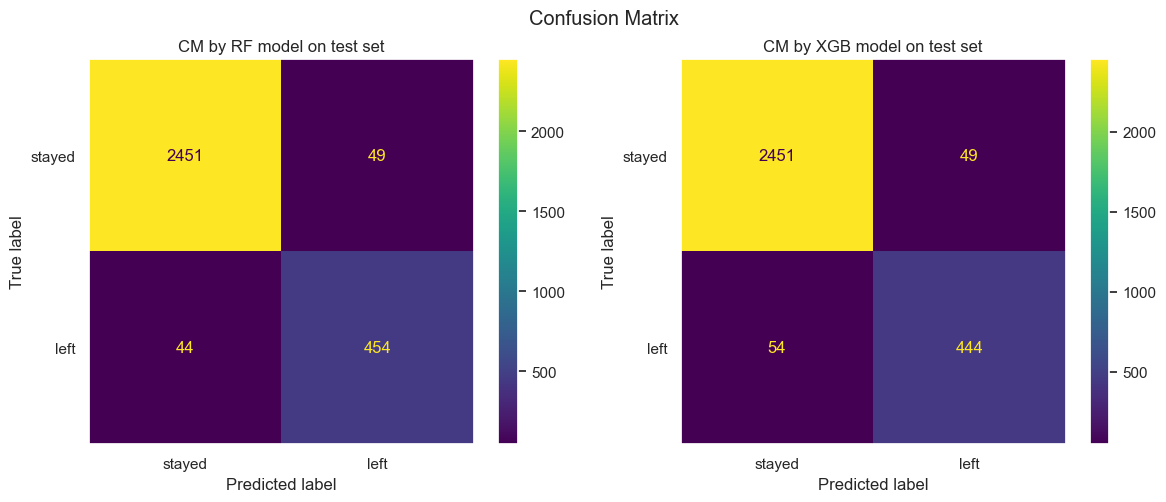

In [96]:
#| echo: false
target_labels = ['stayed', 'left']
# Generate array of values for confusion matrix

cm_rf = confusion_matrix(y_test, rf2_pred, labels=xgb2_cv.classes_)
cm_xgb = confusion_matrix(y_test, xgb2_pred, labels=xgb2_cv.classes_)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Set title for entire figure
plt.suptitle('Confusion Matrix')

# Plot confusion matrix for Random Forest model
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                             display_labels=target_labels)
disp_rf.plot(ax=axes[0],values_format='')
axes[0].set_title('CM by RF model on test set')
axes[0].grid(False)

# Plot confusion matrix for XGBoost model
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                             display_labels=target_labels)
disp_xgb.plot(ax=axes[1],values_format='')
axes[1].set_title('CM by XGB model on test set')
axes[1].grid(False)

plt.show()

#### Feature Importance after Feature Engineering

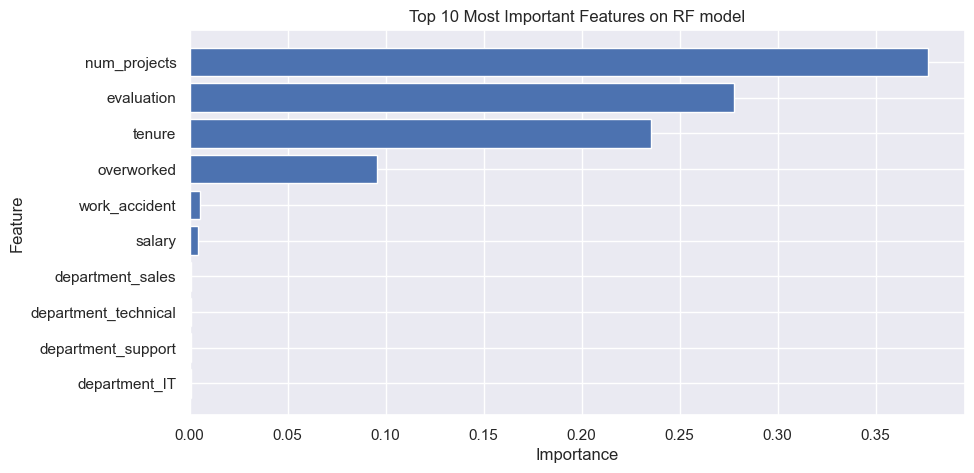

In [97]:
#| echo: false
# Get feature importances
feature_importances = rf2_cv.best_estimator_.feature_importances_

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features on RF model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

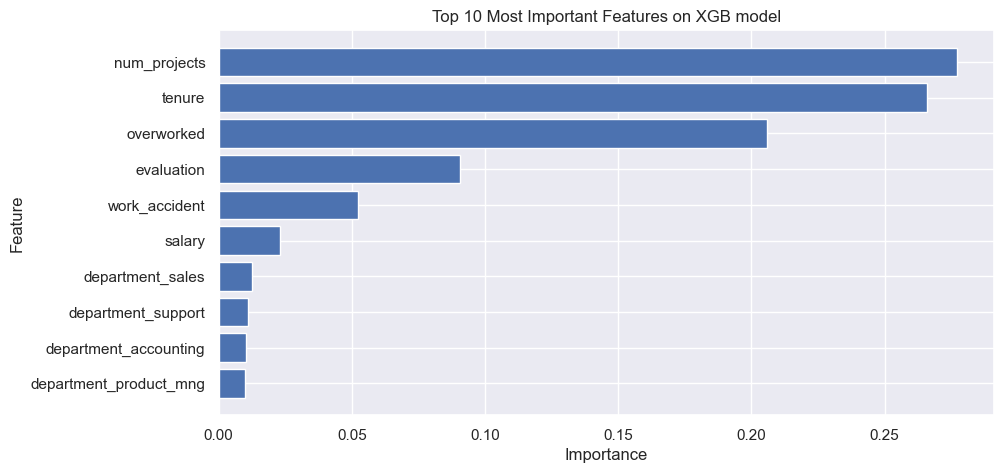

In [98]:
#| echo: false
# Get feature importances
feature_importances = xgb2_cv.best_estimator_.feature_importances_

# Get feature names
feature_names = X_test.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the most important features
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features on XGB model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

Feature importance is crucial for several reasons:

- **Understanding Model Behavior**: Feature importance helps us understand which features or variables have the most significant impact on the model's predictions. This understanding is essential for interpreting and explaining how the model works.
- **Feature Selection**: Feature importance can guide feature selection processes by identifying the most relevant features. This can help improve model performance, reduce overfitting, and speed up training and inference times by focusing on the most informative features.
- **Identifying Insights**: Knowing which features are important can provide insights into the underlying factors driving the predictions. This information can be valuable for making business decisions or understanding the phenomena being modeled.
- **Model Debugging**: Feature importance can also be used for debugging models. If a model's performance is not as expected, examining feature importance can help identify potential issues, such as data quality problems or the presence of irrelevant features.
- **Communicating Results**: Feature importance can be a useful tool for communicating the results of a model to stakeholders who may not be familiar with the technical details of the model. Highlighting important features can make the model's predictions more interpretable and actionable.

Comparing the feature importance between Random Forest and XGBoost can provide insights into how each model weighs the importance of different features for predicting employee attrition. 

Both models emphasize similar features such as the `number of projects`, `tenure`, `last evaluation` and `feeling overworked`, suggesting these factors are crucial in predicting employee attrition. However, there are slight differences in the ranking of importance and the inclusion of additional features in each model, highlighting the nuances in how Random Forest and XGBoost approach the prediction task.

## Interpretation, Communication, and Deployment: 
    
Interpret results, communicate findings to stakeholders, and deploy the model into production if applicable.

### Conclusion

The most crucial features identified from both Random Forest and XGBoost models are `satisfaction`, `tenure`, `num_projects`, `evaluation`, and `avg_monthly_hours`. These align closely with the insights gleaned during the exploratory data analysis (EDA) stage:

- Employees exhibiting satisfaction levels below 0.12 are at a heightened risk of leaving the company, indicating the pivotal role of satisfaction in employee retention.
- Longer tenures, particularly those equal to or exceeding 7 years, serve as a strong indicator of employee retention, suggesting a sense of loyalty or commitment to the organization.
- Conversely, engagement in an excessive number of projects, particularly 7, may signal dissatisfaction or overburdening, leading to higher turnover rates among employees.
- Furthermore, employees involved in 4, 5, or 6 projects, coupled with an above-average workload reflected in their monthly hours, are also inclined to leave, hinting at potential burnout or dissatisfaction with workload management.

These insights underscore the importance of addressing factors such as job satisfaction, workload distribution, and fostering a supportive work environment to mitigate employee turnover and promote retention.

### Summary of Model results

#### Logistics Regression

#### Tree-based Machine Learning

Based on the model performance metrics before and after feature engineering, ***Random Forest with Cross Validation*** appears to be the most appropriate model due to its consistently high accuracy (0.984), precision (0.979), recall (0.922), F1 score (0.949), and AUC (0.959), indicating robust predictive capability across various evaluation metrics.

**1. Accuracy:**
  - High accuracy indicates the model's ability to correctly classify employees as either leaving or staying with the company. This helps in identifying employees at risk of leaving and implementing targeted retention strategies.

**2. Precision:**
 - High precision means that when the model predicts an employee will leave, it is correct most of the time. This is crucial for efficiently allocating resources for retention efforts, ensuring that efforts are focused on employees who are genuinely at risk.

**3. Recall:**
 - High recall indicates the model's ability to identify the majority of employees who actually leave the company. This ensures that a large proportion of employees at risk of leaving are captured, allowing proactive measures to be taken to retain them.

**4. F1 Score:**
- The F1 score balances precision and recall, providing a single metric to assess the model's overall performance in correctly identifying employees who leave the company while minimizing false positives.

**5. AUC (Area Under the Curve):**
- A high AUC value indicates that the model has a strong ability to distinguish between employees who leave and those who stay. This is essential for accurately predicting attrition and prioritizing retention efforts.

### Recommendations,  Next Steps

**1. Focus on Employee Satisfaction:**
   - Implement measures to improve employee satisfaction, especially for those with low satisfaction levels.
   - Consider revising promotion strategies to reward and retain high-performing employees.

**2. Manage Workload:**
- Monitor and manage employee workload to prevent overworking, which may lead to burnout and attrition.
- Optimize project allocation to ensure employees are not overwhelmed with excessive projects.

**3. Tenure-Based Strategies:**
- Develop retention strategies targeted at employees with 4 to 5 years of tenure, as they are more likely to leave.
- Provide career development opportunities and recognition for longer-tenured employees to encourage retention.

**4. Departmental Analysis:**
- Investigate factors contributing to lower attrition rates in Management and R&D departments and implement similar strategies across other departments.

**5. Salary and Promotion Policies:**
- Review salary structures and ensure competitive compensation to reduce attrition.
- Enhance promotion policies to provide growth opportunities and incentivize employee retention.

**6. Regular Employee Feedback:**
- Establish mechanisms for regular employee feedback to identify and address issues contributing to attrition.

**7. Continuous Monitoring:**
- Continuously monitor key metrics such as satisfaction levels, workload, and tenure to proactively identify and mitigate attrition risks.

**8. Prediction and Prevention**
- The selected Random Forest model with Cross Validation demonstrates strong performance across all metrics, indicating its effectiveness in predicting and preventing employee leaving the company. By leveraging this model, organizations can proactively identify employees at risk of leaving and implement targeted retention strategies to improve employee retention rates and maintain workforce stability. 